
# Episode Ratings Trend



In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Get project root (parent of the current notebook folder)
project_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()

csv_path = project_root / 'data' / 'processed' / 'imdb_ratings.csv'
out_path = project_root / 'docs' / 'figures' / 'episode_ratings_trend.png'

df = pd.read_csv(csv_path)
df = df.dropna(subset=['imdb_rating']).copy()
df = df.sort_values(['season', 'episode'])
df['ep_index'] = range(1, len(df) + 1)
df.head()

,season,episode,title,imdb_rating,released,imdb_id,ep_index
0,1,1,Pilot,8.1,2007-09-24,tt0775431,1
1,1,2,The Big Bran Hypothesis,8.2,2007-10-01,tt1091289,2
2,1,3,The Fuzzy Boots Corollary,7.6,2007-10-08,tt1091290,3
3,1,4,The Luminous Fish Effect,8.0,2007-10-15,tt1091291,4
4,1,5,The Hamburger Postulate,7.8,2007-10-22,tt1091292,5


Saved figure to: c:\Users\Bobby\sitcom-humor-lab\docs\figures\episode_ratings_trend.png and c:\Users\Bobby\sitcom-humor-lab\docs\figures\episode_ratings_trend.svg


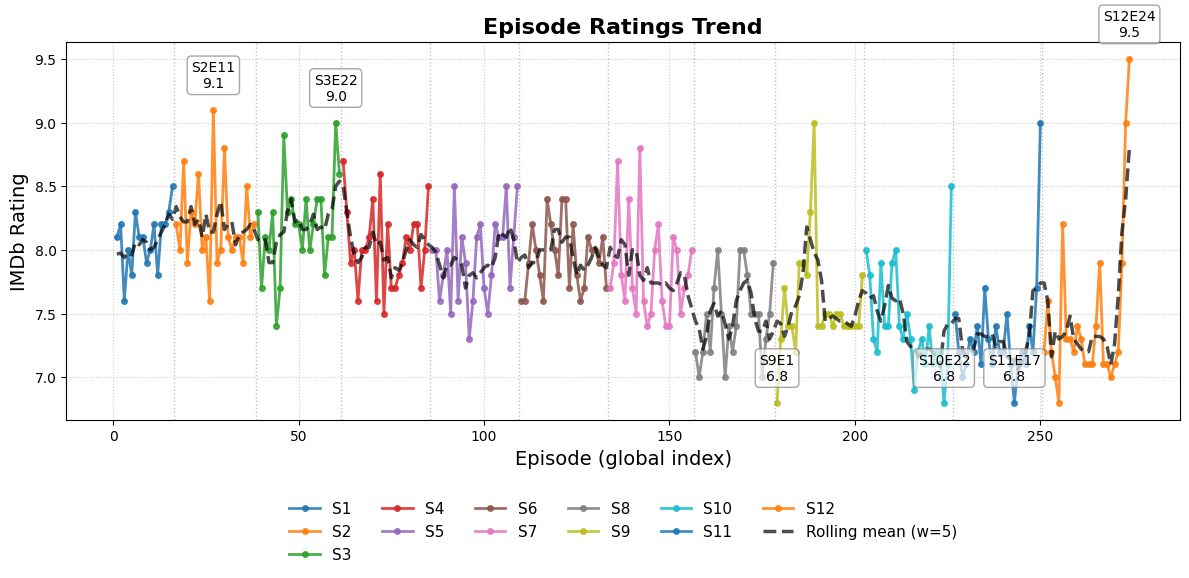

In [24]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# df expected with columns: season, episode, imdb_rating, ep_index

# --- plotting ---
Path(out_path).parent.mkdir(parents=True, exist_ok=True)

# Precompute helpers
df = df.dropna(subset=['imdb_rating']).copy()
df = df.sort_values(['season', 'episode'])
df['ep_index'] = range(1, len(df) + 1)

# Rolling mean over the whole series (tweak window as you like)
df['rolling_mean'] = df['imdb_rating'].rolling(window=5, center=True, min_periods=1).mean()

# Use a color palette for seasons
season_list = sorted(df['season'].unique())
palette = sns.color_palette('tab10', n_colors=len(season_list))

fig, ax = plt.subplots(figsize=(12, 6))

# Per-season lines with color palette and transparency
for idx, s in enumerate(season_list):
    sub = df[df['season'] == s]
    ax.plot(sub['ep_index'], sub['imdb_rating'], marker='o', linestyle='-', label=f'S{s}',
            linewidth=2, markersize=4, color=palette[idx], alpha=0.85)

# Global rolling mean overlay
ax.plot(df['ep_index'], df['rolling_mean'], linestyle='--', linewidth=2.5, label='Rolling mean (w=5)', color='black', alpha=0.7)

# Season boundary markers (vertical lines at season ends)
season_ends = df.groupby('season')['ep_index'].max().tolist()
for x in season_ends[:-1]:  # no line after the final season
    ax.axvline(x + 0.5, linestyle=':', linewidth=1, alpha=0.5, color='gray')

# Top/bottom episode annotations (n = 3 by default)
def annotate_extremes(frame: pd.DataFrame, n: int = 3):
    top = frame.nlargest(n, 'imdb_rating')
    bot = frame.nsmallest(n, 'imdb_rating')
    for _, r in pd.concat([top, bot]).iterrows():
        ax.annotate(
            f"S{int(r.season)}E{int(r.episode)}\n{r.imdb_rating:.1f}",
            xy=(r.ep_index, r.imdb_rating),
            xytext=(0, 14),
            textcoords="offset points",
            ha='center', va='bottom',
            fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='gray', alpha=0.7)
        )

annotate_extremes(df, n=3)

# Cosmetics
ax.set_xlabel('Episode (global index)', fontsize=14)
ax.set_ylabel('IMDb Rating', fontsize=14)
ax.set_title('Episode Ratings Trend', fontsize=16, fontweight='bold')
ax.grid(True, which='both', linestyle=':', linewidth=0.8, alpha=0.4, color='gray')

# Put legend below to avoid clutter
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.18), ncol=6, fontsize=11, frameon=False)

fig.tight_layout()

# Save PNG + SVG
fig.savefig(out_path, dpi=300, bbox_inches='tight')
fig.savefig(str(Path(out_path).with_suffix('.svg')), bbox_inches='tight')
print(f"Saved figure to: {out_path} and {Path(out_path).with_suffix('.svg')}")